### Upload do arquivo csv

In [ ]:
from google.colab import files
uploaded = files.upload()

### Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix


### Função de Suporte



In [ ]:
def calcular_media_individual_por_chave(dicionario):
    medias_por_chave = {}
    std_por_chave = {}

    for chave, valores in dicionario.items():
            media = np.mean(valores)
            std = np.std(valores)
            medias_por_chave[chave] = media
            std_por_chave[chave] = std
    return medias_por_chave, std_por_chave

### Carregando Dataset

In [ ]:
data = pd.read_csv("breast.csv")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

### Holdout e Normalização

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Definindo Cross Validation 10 folds

In [ ]:
folds = 10

fold_size = len(X) // folds

folds_X = np.array_split(X, folds)
folds_y = np.array_split(y, folds)

### Código para Regressão Logística

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def gradient_descent(X, y, w, learning_rate, num_iterations):
    n_samples, n_features = X.shape

    for _ in range(num_iterations):
        y_pred = np.dot(X, w)
        h = sigmoid(y_pred)
        gradient = -1/n_samples * np.dot(X.T, (y - h))
        w -= learning_rate * gradient

    return w

def cross_entropy_loss(w, X, y):
    m = len(y)
    y_pred = np.dot(X, w)
    h = sigmoid(y_pred)
    loss = -1/m * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return loss

def logistic_regression(X, y, learning_rate, num_iterations):
    n_samples, n_features = X.shape
    w = np.random.randn(n_features)
    loss_history = []

    for _ in range(num_iterations):
        w = gradient_descent(X, y, w, learning_rate, 1)
        loss = cross_entropy_loss(w, X, y)
        loss_history.append(loss)

    return w, loss_history

def predict(X, weights, threshold=0.5):
    y_pred = np.dot(X, weights)
    y_pred = sigmoid(y_pred)
    return (y_pred >= threshold).astype(int)

In [ ]:
learning_rate = 0.1
num_iterations = 250

weights, loss_history = logistic_regression(X_train, y_train, learning_rate, num_iterations)

print("Histórico de Perda (Loss History):")
for i, loss in enumerate(loss_history):
    print(f"Iteração {i + 1}: Loss = {loss}")

print("Pesos (Coefficients):", weights)

y_pred = predict(X_test, weights)

Histórico de Perda (Loss History):
Iteração 1: Loss = 2.4424136697174847
Iteração 2: Loss = 2.0509961925147584
Iteração 3: Loss = 1.7245499264678752
Iteração 4: Loss = 1.4650110416735247
Iteração 5: Loss = 1.2617274142403287
Iteração 6: Loss = 1.1017495065642031
Iteração 7: Loss = 0.974495138933887
Iteração 8: Loss = 0.8715050367938858
Iteração 9: Loss = 0.7866770132035414
Iteração 10: Loss = 0.7157618384562043
Iteração 11: Loss = 0.6558181548062795
Iteração 12: Loss = 0.6047528655573622
Iteração 13: Loss = 0.5609796111584338
Iteração 14: Loss = 0.5232220845899617
Iteração 15: Loss = 0.49042448119182397
Iteração 16: Loss = 0.46171444717363785
Iteração 17: Loss = 0.43638037786091766
Iteração 18: Loss = 0.4138486635121851
Iteração 19: Loss = 0.39366007747102305
Iteração 20: Loss = 0.37544771394035337
Iteração 21: Loss = 0.3589180011473372
Iteração 22: Loss = 0.3438351299598841
Iteração 23: Loss = 0.3300086171083931
Iteração 24: Loss = 0.3172835139830827
Iteração 25: Loss = 0.305532754588

In [ ]:
cm = confusion_matrix(y_test, y_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

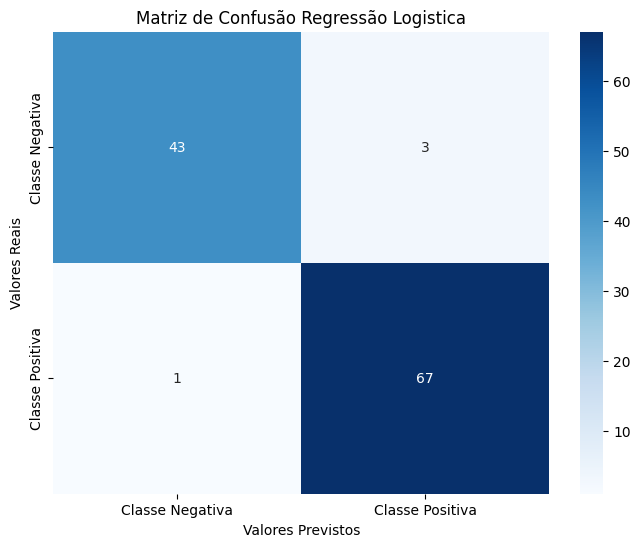

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão Regressão Logistica')
plt.show()

In [ ]:
accuracy = ((TN + TP)/(TN + FP + TP + FN))
recall = ((TP)/(TP + FN))
precision = ((TP)/(TP + FP))
F1_score = (2 * ((precision * recall)/(precision + recall)))

In [ ]:
metrics_lr = pd.DataFrame({
    'Metrica': ['Accuracy', 'Recall', 'Precision', 'F1_score'],
    'Valor': [accuracy, recall, precision, F1_score]
})
metrics_lr.style.set_caption('Regressão Logística')

,Metrica,Valor
0,Accuracy,0.964912
1,Recall,0.985294
2,Precision,0.957143
3,F1_score,0.971014


### Código para Regressão Logística com cross validation

In [ ]:
metrics_dict_lr_cv = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'F1_score': []
}

confusion_matrix_lr_cv = []

for i in range(folds):

    X_train = np.concatenate(folds_X[:i] + folds_X[i+1:])
    y_train = np.concatenate(folds_y[:i] + folds_y[i+1:])

    X_test = folds_X[i]
    y_test = folds_y[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    weights, loss_history = logistic_regression(X_train, y_train, learning_rate, num_iterations)

    y_pred = predict(X_test, weights)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_lr_cv.append(cm)

    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    accuracy = ((TN + TP)/(TN + FP + TP + FN))
    recall = ((TP)/(TP + FN))
    precision = ((TP)/(TP + FP))
    F1_score = (2 * ((precision * recall)/(precision + recall)))

    metrics_dict_lr_cv['accuracy'].append(accuracy)
    metrics_dict_lr_cv['recall'].append(recall)
    metrics_dict_lr_cv['precision'].append(precision)
    metrics_dict_lr_cv['F1_score'].append(F1_score)



In [ ]:
lr_cv_cm_sum = np.sum(confusion_matrix_lr_cv, axis=0)

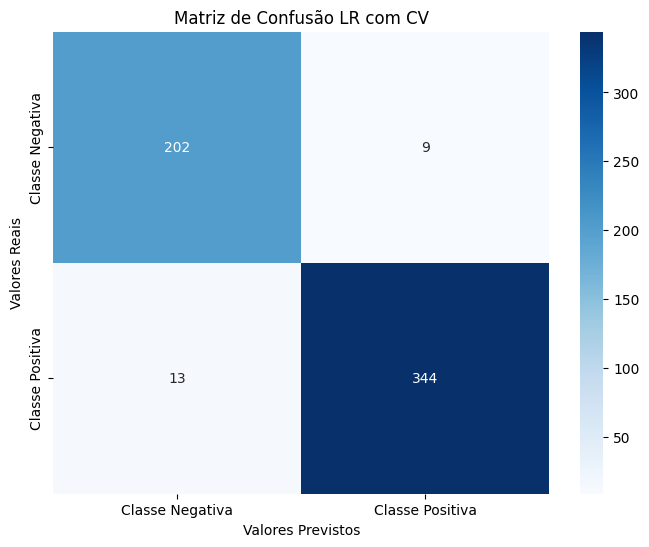

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cv_cm_sum, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão LR com CV')
plt.show()

In [ ]:
medias_individual_por_chave_lr_cv = calcular_media_individual_por_chave(metrics_dict_lr_cv)

In [ ]:
df_lr_cv = pd.DataFrame({'Média': medias_individual_por_chave_lr_cv[0], 'Desvio Padrão': medias_individual_por_chave_lr_cv[1]})
df_lr_cv.style.set_caption('Logistic Regression CV')

,Média,Desvio Padrão
accuracy,0.961216,0.032551
recall,0.965477,0.043087
precision,0.965108,0.045667
F1_score,0.964013,0.029610


### Código para Análise do Discriminante Gaussiano

In [ ]:
def calcular_media(valores):
    return sum(valores) / len(valores)

def matriz_covariancia(dados):
    num_colunas = len(dados[0])
    num_linhas = len(dados)

    medias = [calcular_media([dados[i][j] for i in range(num_linhas)]) for j in range(num_colunas)]
    matriz_covariancia = [[0] * num_colunas for _ in range(num_colunas)]
    for i in range(num_colunas):
        for j in range(num_colunas):
            soma_covariancia = 0
            for k in range(num_linhas):
                soma_covariancia += (dados[k][i] - medias[i]) * (dados[k][j] - medias[j])
            matriz_covariancia[i][j] = soma_covariancia / (num_linhas - 1)

    return matriz_covariancia


In [ ]:
classe1_dados = X_train[y_train == 0]
classe2_dados = X_train[y_train == 1]

mu_chapeu_1 = calcular_media(classe1_dados)
mu_chapeu_2 = calcular_media(classe2_dados)
sigma_chapeu_1 = matriz_covariancia(classe1_dados)
sigma_chapeu_2 = matriz_covariancia(classe2_dados)

p_C1 = calcular_media(y_train == 0)
p_C2 = calcular_media(y_train == 1)

In [ ]:
def classificador_adg(x, mu_chapeu_1, mu_chapeu_2, sigma_chapeu_1, sigma_chapeu_2, p_C1, p_C2):

    p_x_C1 = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma_chapeu_1))) * np.exp(-0.5 * np.dot(np.dot((x - mu_chapeu_1).T, np.linalg.inv(sigma_chapeu_1)), (x - mu_chapeu_1)))
    p_x_C2 = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma_chapeu_2))) * np.exp(-0.5 * np.dot(np.dot((x - mu_chapeu_2).T, np.linalg.inv(sigma_chapeu_2)), (x - mu_chapeu_2)))

    p_C1_x = p_x_C1 * p_C1
    p_C2_x = p_x_C2 * p_C2

    if p_C1_x > p_C2_x:
        return 0
    else:
        return 1

In [ ]:
y_pred = [classificador_adg(x, mu_chapeu_1, mu_chapeu_2, sigma_chapeu_1, sigma_chapeu_2, p_C1, p_C2) for x in X_test]

In [ ]:
cm_adg = confusion_matrix(y_test, y_pred)

TN = cm_adg[0, 0]
FP = cm_adg[0, 1]
FN = cm_adg[1, 0]
TP = cm_adg[1, 1]

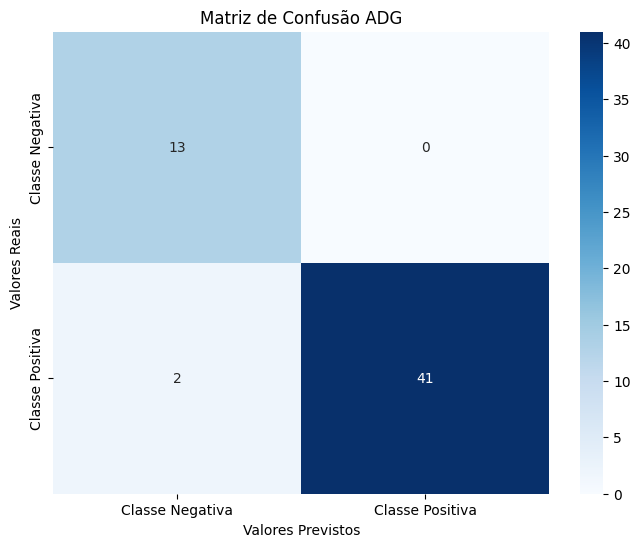

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adg, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão ADG')
plt.show()

In [ ]:
accuracy = ((TN + TP)/(TN + FP + TP + FN))
recall = ((TP)/(TP + FN))
precision = ((TP)/(TP + FP))
F1_score = (2 * ((precision * recall)/(precision + recall)))

In [ ]:
metrics_adg = pd.DataFrame({
    'Metrica': ['Accuracy', 'Recall', 'Precision', 'F1_score'],
    'Valor': [accuracy, recall, precision, F1_score]
})
metrics_adg.style.set_caption('Análise do Discriminante Gaussiano')

,Metrica,Valor
0,Accuracy,0.964286
1,Recall,0.953488
2,Precision,1.000000
3,F1_score,0.976190


### Código para Análise do Discriminante Gaussiano com cross validation



In [ ]:
metrics_dict_adg_cv = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'F1_score': []
}

confusion_matrix_adg_cv = []

for i in range(folds):

    X_train = np.concatenate(folds_X[:i] + folds_X[i+1:])
    y_train = np.concatenate(folds_y[:i] + folds_y[i+1:])

    X_test = folds_X[i]
    y_test = folds_y[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    classe1_dados = X_train[y_train == 0]
    classe2_dados = X_train[y_train == 1]

    mu_chapeu_1 = calcular_media(classe1_dados)
    mu_chapeu_2 = calcular_media(classe2_dados)
    sigma_chapeu_1 = matriz_covariancia(classe1_dados)
    sigma_chapeu_2 = matriz_covariancia(classe2_dados)

    p_C1 = calcular_media(y_train == 0)
    p_C2 = calcular_media(y_train == 1)


    y_pred = [classificador_adg(x, mu_chapeu_1, mu_chapeu_2, sigma_chapeu_1, sigma_chapeu_2, p_C1, p_C2) for x in X_test]

    cm_adg = confusion_matrix(y_test, y_pred)
    confusion_matrix_adg_cv.append(cm_adg)

    TN = cm_adg[0, 0]
    FP = cm_adg[0, 1]
    FN = cm_adg[1, 0]
    TP = cm_adg[1, 1]

    accuracy = ((TN + TP)/(TN + FP + TP + FN))
    recall = ((TP)/(TP + FN))
    precision = ((TP)/(TP + FP))
    F1_score = (2 * ((precision * recall)/(precision + recall)))

    metrics_dict_adg_cv['accuracy'].append(accuracy)
    metrics_dict_adg_cv['recall'].append(recall)
    metrics_dict_adg_cv['precision'].append(precision)
    metrics_dict_adg_cv['F1_score'].append(F1_score)



In [ ]:
adg_cv_cm_sum = np.sum(confusion_matrix_adg_cv, axis=0)

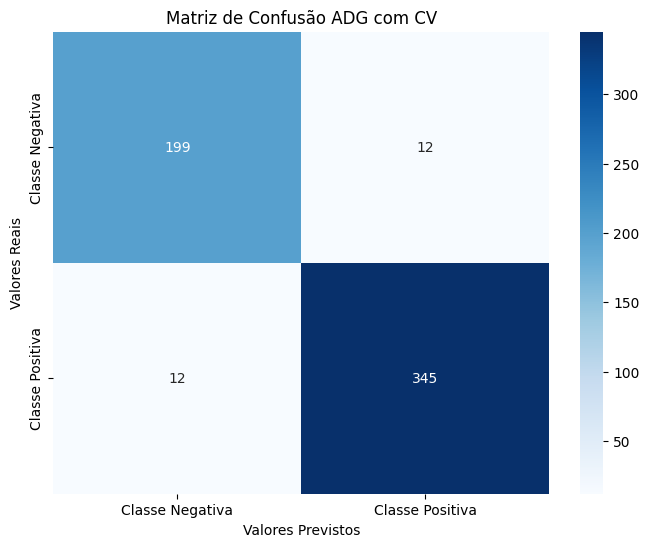

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(adg_cv_cm_sum, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão ADG com CV')
plt.show()

In [ ]:
medias_individual_por_chave_adg_cv = calcular_media_individual_por_chave(metrics_dict_adg_cv)

In [ ]:
df_adg_cv = pd.DataFrame({'Média': medias_individual_por_chave_adg_cv[0], 'Desvio Padrão': medias_individual_por_chave_adg_cv[1]})
df_adg_cv.style.set_caption('Análise do Discriminante Gaussiano CV')

,Média,Desvio Padrão
accuracy,0.957738,0.011689
recall,0.970248,0.019911
precision,0.957094,0.043829
F1_score,0.962660,0.017558


### Código para o Naive Bayes Gaussiano


In [ ]:
def calcular_variancia(dados):
    n = len(dados)
    if n == 0:
        return 0.0

    variancia = sum((x - calcular_media(dados)) ** 2 for x in dados) / (n - 1)
    return variancia

In [ ]:
classe1_dados = X_train[y_train == 0]
classe2_dados = X_train[y_train == 1]

mu_chapeu_1 = calcular_media(classe1_dados)
mu_chapeu_2 = calcular_media(classe2_dados)
sigma_chapeu_1 = calcular_variancia(classe1_dados)
sigma_chapeu_2 = calcular_variancia(classe2_dados)


N = len(X_train)
p_C1 = len(classe1_dados) / N
p_C2 = len(classe2_dados) / N

def classificador_nbg(x, mu_chapeu_1, mu_chapeu_2, sigma_chapeu_1, sigma_chapeu_2, p_C1, p_C2):
    p_x_C1 = 1
    p_x_C2 = 1

    for d in range(len(x)):
        p_x_C1 *= 1 / (np.sqrt(2 * np.pi * sigma_chapeu_1[d])) * np.exp(-0.5 * ((x[d] - mu_chapeu_1[d]) ** 2) / sigma_chapeu_1[d])
        p_x_C2 *= 1 / (np.sqrt(2 * np.pi * sigma_chapeu_2[d])) * np.exp(-0.5 * ((x[d] - mu_chapeu_2[d]) ** 2) / sigma_chapeu_2[d])

    p_C1_x = p_x_C1 * p_C1
    p_C2_x = p_x_C2 * p_C2

    if p_C1_x > p_C2_x:
        return 0
    else:
        return 1

In [ ]:
y_pred = [classificador_nbg(x, mu_chapeu_1, mu_chapeu_2, sigma_chapeu_1, sigma_chapeu_2, p_C1, p_C2) for x in X_test]

In [ ]:
cm_nbg = confusion_matrix(y_test, y_pred)

TN = cm_nbg[0, 0]
FP = cm_nbg[0, 1]
FN = cm_nbg[1, 0]
TP = cm_nbg[1, 1]

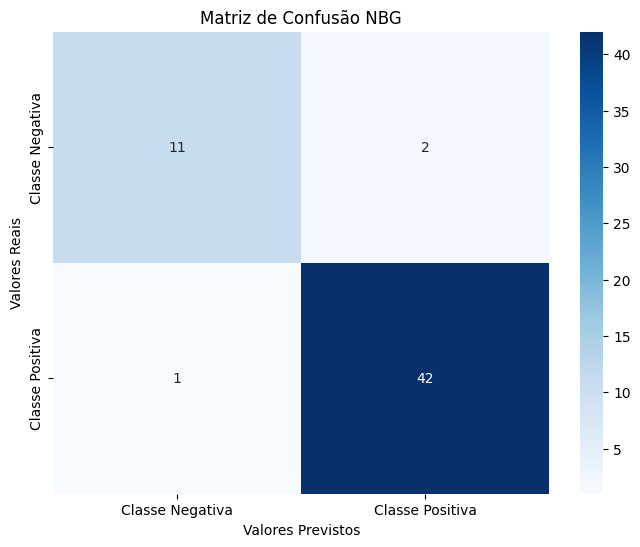

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nbg, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão NBG')
plt.show()

In [ ]:
accuracy = ((TN + TP)/(TN + FP + TP + FN))
recall = ((TP)/(TP + FN))
precision = ((TP)/(TP + FP))
F1_score = (2 * ((precision * recall)/(precision + recall)))

In [ ]:
metrics_nbg = pd.DataFrame({
    'Metrica': ['Accuracy', 'Recall', 'Precision', 'F1_score'],
    'Valor': [accuracy, recall, precision, F1_score]
})
metrics_nbg.style.set_caption('Nayve Bayes Gaussiano')

,Metrica,Valor
0,Accuracy,0.946429
1,Recall,0.976744
2,Precision,0.954545
3,F1_score,0.965517


### Código para o Naive Bayes Gaussiano com Cross Validation

In [ ]:
metrics_dict_nbg_cv = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'F1_score': []
}

confusion_matrix_nbg_cv = []

for i in range(folds):

    X_train = np.concatenate(folds_X[:i] + folds_X[i+1:])
    y_train = np.concatenate(folds_y[:i] + folds_y[i+1:])

    X_test = folds_X[i]
    y_test = folds_y[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    classe1_dados = X_train[y_train == 0]
    classe2_dados = X_train[y_train == 1]

    mu_chapeu_1 = calcular_media(classe1_dados)
    mu_chapeu_2 = calcular_media(classe2_dados)
    sigma_chapeu_1 = calcular_variancia(classe1_dados)
    sigma_chapeu_2 = calcular_variancia(classe2_dados)


    N = len(X_train)
    p_C1 = len(classe1_dados) / N
    p_C2 = len(classe2_dados) / N



    y_pred = [classificador_nbg(x, mu_chapeu_1, mu_chapeu_2, sigma_chapeu_1, sigma_chapeu_2, p_C1, p_C2) for x in X_test]

    cm_nbg = confusion_matrix(y_test, y_pred)
    confusion_matrix_nbg_cv.append(cm_adg)

    TN = cm_nbg[0, 0]
    FP = cm_nbg[0, 1]
    FN = cm_nbg[1, 0]
    TP = cm_nbg[1, 1]

    accuracy = ((TN + TP)/(TN + FP + TP + FN))
    recall = ((TP)/(TP + FN))
    precision = ((TP)/(TP + FP))
    F1_score = (2 * ((precision * recall)/(precision + recall)))

    metrics_dict_nbg_cv['accuracy'].append(accuracy)
    metrics_dict_nbg_cv['recall'].append(recall)
    metrics_dict_nbg_cv['precision'].append(precision)
    metrics_dict_nbg_cv['F1_score'].append(F1_score)



In [ ]:
nbg_cv_cm_sum = np.sum(confusion_matrix_nbg_cv, axis=0)

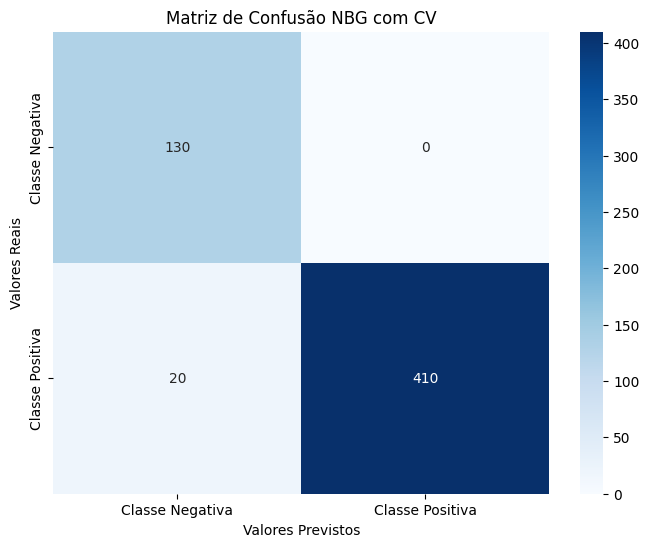

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(nbg_cv_cm_sum, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão NBG com CV')
plt.show()

In [ ]:
medias_individual_por_chave_nbg_cv = calcular_media_individual_por_chave(metrics_dict_nbg_cv)

In [ ]:
df_nbg_cv = pd.DataFrame({'Média': medias_individual_por_chave_nbg_cv[0], 'Desvio Padrão': medias_individual_por_chave_nbg_cv[1]})
df_nbg_cv.style.set_caption('Nayve Bayes Gaussiano CV')

,Média,Desvio Padrão
accuracy,0.927788,0.039698
recall,0.953873,0.047018
precision,0.919436,0.086449
F1_score,0.932938,0.050331


### Código para o  KNN

In [ ]:
def distancia_euclidiana(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))



def knn_predict(X_train, y_train, X_test, k):
    distancias = [(distancia_euclidiana(X_test, x), i) for i, x in enumerate(X_train)]
    distancias_ordenadas = sorted(distancias, key=lambda x: x[0])[:k]
    k_indices = [i for _, i in distancias_ordenadas]
    k_rotulos_mais_proximos = [y_train[i] for i in k_indices]

    contagem_classes = {}
    for rotulo in k_rotulos_mais_proximos:
        if rotulo in contagem_classes:
            contagem_classes[rotulo] += 1
        else:
            contagem_classes[rotulo] = 1

    y_pred = max(contagem_classes, key=lambda x: -contagem_classes[x])
    return y_pred


k = 3


In [ ]:
y_pred = [knn_predict(X_train, y_train, x, k) for x in X_test]


In [ ]:
cm_knn = confusion_matrix(y_test, y_pred)

TN = cm_knn[0, 0]
FP = cm_knn[0, 1]
FN = cm_knn[1, 0]
TP = cm_knn[1, 1]

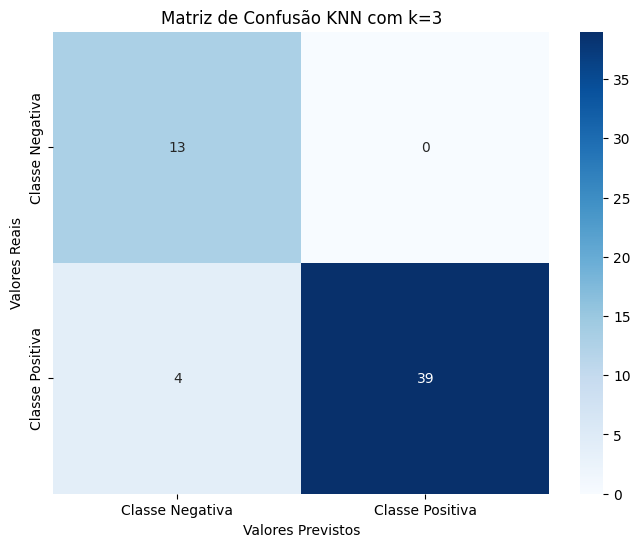

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão KNN com k=3')
plt.show()

In [ ]:
accuracy = ((TN + TP)/(TN + FP + TP + FN))
recall = ((TP)/(TP + FN))
precision = ((TP)/(TP + FP))
F1_score = (2 * ((precision * recall)/(precision + recall)))

In [ ]:
metrics_knn = pd.DataFrame({
    'Metrica': ['Accuracy', 'Recall', 'Precision', 'F1_score'],
    'Valor': [accuracy, recall, precision, F1_score]
})
metrics_knn.style.set_caption('K Nearest Neighbors')

,Metrica,Valor
0,Accuracy,0.928571
1,Recall,0.906977
2,Precision,1.000000
3,F1_score,0.951220


### Código para o  KNN com Cross Validation



In [ ]:
metrics_dict_knn_cv = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'F1_score': []
}

confusion_matrix_knn_cv = []

for i in range(folds):

    X_train = np.concatenate(folds_X[:i] + folds_X[i+1:])
    y_train = np.concatenate(folds_y[:i] + folds_y[i+1:])

    X_test = folds_X[i]
    y_test = folds_y[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_pred = [knn_predict(X_train, y_train, x, k) for x in X_test]

    cm_knn = confusion_matrix(y_test, y_pred)
    confusion_matrix_knn_cv.append(cm_knn)

    TN = cm_knn[0, 0]
    FP = cm_knn[0, 1]
    FN = cm_knn[1, 0]
    TP = cm_knn[1, 1]

    accuracy = ((TN + TP)/(TN + FP + TP + FN))
    recall = ((TP)/(TP + FN))
    precision = ((TP)/(TP + FP))
    F1_score = (2 * ((precision * recall)/(precision + recall)))

    metrics_dict_knn_cv['accuracy'].append(accuracy)
    metrics_dict_knn_cv['recall'].append(recall)
    metrics_dict_knn_cv['precision'].append(precision)
    metrics_dict_knn_cv['F1_score'].append(F1_score)

In [ ]:
knn_cv_cm_sum = np.sum(confusion_matrix_knn_cv, axis=0)

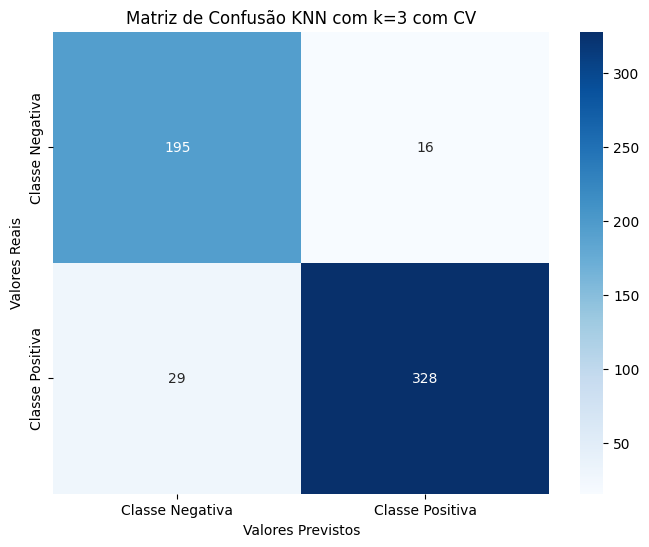

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cv_cm_sum, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão KNN com k=3 com CV')
plt.show()

In [ ]:
medias_individual_por_chave_knn_cv = calcular_media_individual_por_chave(metrics_dict_knn_cv)

In [ ]:
df_nbg_cv = pd.DataFrame({'Média': medias_individual_por_chave_knn_cv[0], 'Desvio Padrão': medias_individual_por_chave_knn_cv[1]})
df_nbg_cv.style.set_caption('K Nearest Neighbors')

,Média,Desvio Padrão
accuracy,0.920708,0.033778
recall,0.922883,0.051319
precision,0.935374,0.090720
F1_score,0.924781,0.047646
